# Analysis of H5 mouse sera strain neuts

In [25]:
import os
import warnings
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import altair as alt

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [26]:
warnings.simplefilter('ignore')

Read config file.

In [27]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [28]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [29]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [30]:
frac_infect = pd.read_csv(config['serum_neuts_mouse_pHW_strain_validation'], index_col=0)

## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [31]:
fits = neutcurve.CurveFits(frac_infect,  fixtop= True)

In [32]:
fitparams = (
        fits.fitParams(ics=[50,90])
        # get columns of interest
        [['serum', 'ic50', 'ic50_bound', 'ic90', 'virus']]
        .assign(NT50=lambda x: 1/x['ic50'], NT90=lambda x: 1/x['ic90'])        
        )

In [33]:
fitparams

,serum,ic50,ic50_bound,ic90,virus,NT50,NT90
0,mouse-serum-1-02,0.000087,interpolated,0.000284,A/American Wigeon/South Carolina/USDA-000345-0...,11537.886677,3527.292115
1,mouse-serum-1-02,0.001307,interpolated,0.006837,A/domesticcat/Oklahoma/24009118002/2024,765.195066,146.267803
2,mouse-serum-1-02,0.003000,interpolated,0.013007,A/dairycattle/Texas/24009028003/2024,333.371588,76.880537
3,mouse-serum-1-02,0.000953,interpolated,0.003389,A/skunk/NewMexico/24006483001original/2024,1048.876178,295.068688
4,mouse-serum-1-02,0.000121,interpolated,0.000820,A/peregrinefalcon/Saga/4112A002/2023,8278.631239,1219.391473
5,mouse-serum-1-03,0.000105,interpolated,0.000632,A/American Wigeon/South Carolina/USDA-000345-0...,9552.303369,1582.826792
6,mouse-serum-1-03,0.001096,interpolated,0.009167,A/domesticcat/Oklahoma/24009118002/2024,912.123405,109.089500
7,mouse-serum-1-03,0.001933,interpolated,0.008373,A/dairycattle/Texas/24009028003/2024,517.308722,119.426536
8,mouse-serum-1-03,0.001818,interpolated,0.008798,A/skunk/NewMexico/24006483001original/2024,550.153661,113.660301
9,mouse-serum-1-03,0.000117,interpolated,0.000563,A/peregrinefalcon/Saga/4112A002/2023,8515.725219,1775.945868


## Plot neut curves for sera

Saving to mouse_H5_sera_strain_validation_neuts.pdf


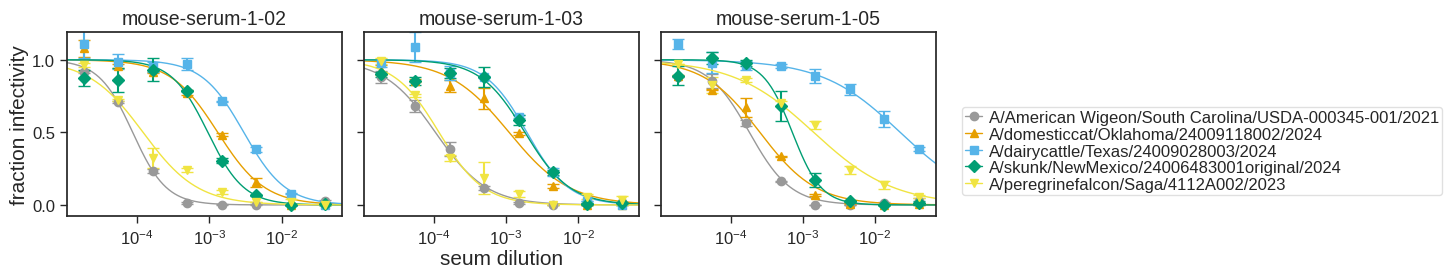

In [34]:
fig, axes = fits.plotSera(xlabel='seum dilution',
                          max_viruses_per_subplot = 6
                         )
plotfile = 'mouse_H5_sera_strain_validation_neuts.pdf'
print(f"Saving to {plotfile}")
fig.savefig(f'{resultsdir}/{plotfile}', bbox_inches='tight')

## Correlate to DMS data

In [35]:
strains = pd.read_csv(config['strains'])

In [36]:
mouse2_escape = pd.read_csv(config['mouse_1-02_sera_escape'])
m2_strains = strains.merge(mouse2_escape[['mutation','escape_mean']], on='mutation', how='left')
m2_escape = m2_strains.groupby('strain', as_index=False)['escape_mean'].sum()
m2_escape['serum'] = 'mouse-serum-1-02'
m2_df = m2_escape.merge(fitparams[['virus','ic90', 'serum']], left_on=['strain', 'serum'], right_on=['virus','serum'], how='left')
m2_df = m2_df[['serum', 'strain', 'escape_mean', 'ic90']]
m2_df

,serum,strain,escape_mean,ic90
0,mouse-serum-1-02,A/American Wigeon/South Carolina/USDA-000345-0...,0.00000,0.000284
1,mouse-serum-1-02,A/dairycattle/Texas/24009028003/2024,1.35980,0.013007
2,mouse-serum-1-02,A/domesticcat/Oklahoma/24009118002/2024,1.28940,0.006837
3,mouse-serum-1-02,A/peregrinefalcon/Saga/4112A002/2023,0.76981,0.000820
4,mouse-serum-1-02,A/skunk/NewMexico/24006483001original/2024,2.11960,0.003389


In [38]:
mouse3_escape = pd.read_csv(config['mouse_1-03_sera_escape'])
m3_strains = strains.merge(mouse3_escape[['mutation','escape_mean']], on='mutation', how='left')
# m3_strains.loc[m3_strains['escape_mean'] < 0, 'escape_mean'] = 0
m3_escape = m3_strains.groupby('strain', as_index=False)['escape_mean'].sum()
m3_escape['serum'] = 'mouse-serum-1-03'
m3_df = m3_escape.merge(fitparams[['virus','ic90', 'serum']], left_on=['strain', 'serum'], right_on=['virus','serum'], how='left')
m3_df = m3_df[['serum', 'strain', 'escape_mean', 'ic90']]
m3_df

,serum,strain,escape_mean,ic90
0,mouse-serum-1-03,A/American Wigeon/South Carolina/USDA-000345-0...,0.000000,0.000632
1,mouse-serum-1-03,A/dairycattle/Texas/24009028003/2024,2.373267,0.008373
2,mouse-serum-1-03,A/domesticcat/Oklahoma/24009118002/2024,2.292534,0.009167
3,mouse-serum-1-03,A/peregrinefalcon/Saga/4112A002/2023,-0.283184,0.000563
4,mouse-serum-1-03,A/skunk/NewMexico/24006483001original/2024,2.782617,0.008798


In [39]:
mouse5_escape = pd.read_csv(config['mouse_1-05_sera_escape'])
m5_strains = strains.merge(mouse5_escape[['mutation','escape_mean']], on='mutation', how='left')
# m5_strains.loc[m5_strains['escape_mean'] < 0, 'escape_mean'] = 0
m5_escape = m5_strains.groupby('strain', as_index=False)['escape_mean'].sum()
m5_escape['serum'] = 'mouse-serum-1-05'
m5_df = m5_escape.merge(fitparams[['virus','ic90', 'serum']], left_on=['strain', 'serum'], right_on=['virus','serum'], how='left')
m5_df = m5_df[['serum', 'strain', 'escape_mean', 'ic90']]
m5_df

,serum,strain,escape_mean,ic90
0,mouse-serum-1-05,A/American Wigeon/South Carolina/USDA-000345-0...,0.000000,0.000774
1,mouse-serum-1-05,A/dairycattle/Texas/24009028003/2024,2.225500,0.040000
2,mouse-serum-1-05,A/domesticcat/Oklahoma/24009118002/2024,2.140500,0.001816
3,mouse-serum-1-05,A/peregrinefalcon/Saga/4112A002/2023,3.170689,0.023300
4,mouse-serum-1-05,A/skunk/NewMexico/24006483001original/2024,1.865500,0.001963


In [40]:
merge_df = pd.concat([m2_df, m3_df, m5_df], ignore_index=True)
merge_df

,serum,strain,escape_mean,ic90
0,mouse-serum-1-02,A/American Wigeon/South Carolina/USDA-000345-0...,0.000000,0.000284
1,mouse-serum-1-02,A/dairycattle/Texas/24009028003/2024,1.359800,0.013007
2,mouse-serum-1-02,A/domesticcat/Oklahoma/24009118002/2024,1.289400,0.006837
3,mouse-serum-1-02,A/peregrinefalcon/Saga/4112A002/2023,0.769810,0.000820
4,mouse-serum-1-02,A/skunk/NewMexico/24006483001original/2024,2.119600,0.003389
5,mouse-serum-1-03,A/American Wigeon/South Carolina/USDA-000345-0...,0.000000,0.000632
6,mouse-serum-1-03,A/dairycattle/Texas/24009028003/2024,2.373267,0.008373
7,mouse-serum-1-03,A/domesticcat/Oklahoma/24009118002/2024,2.292534,0.009167
8,mouse-serum-1-03,A/peregrinefalcon/Saga/4112A002/2023,-0.283184,0.000563
9,mouse-serum-1-03,A/skunk/NewMexico/24006483001original/2024,2.782617,0.008798


In [41]:
# Calculate the correlation for each subset of data
merge_df['log_ic90'] = np.log(merge_df['ic90'])

# Calculate the correlation on the log-transformed IC90 values
correlations = merge_df.groupby('serum').apply(lambda df: df['escape_mean'].corr(df['log_ic90'])).reset_index()
correlations.columns = ['serum', 'correlation']

# Merge the correlation values back to the original DataFrame
merge_df = merge_df.merge(correlations, on='serum')

In [45]:
# Base chart
base = alt.Chart(merge_df).mark_point(filled=True, size=100).encode(
    x=alt.X('escape_mean', scale=alt.Scale(padding=10)),
    y=alt.Y('ic90', scale=alt.Scale(nice=False, type='log', padding=5)),
    color=alt.Color('strain', legend=alt.Legend(orient='right', title='Strain', titleLimit=200, labelLimit=200))
).properties(
    width=200,
    height=200
)

# Text chart for R values
text = alt.Chart(merge_df).mark_text(
    align='left',
    baseline='top',
    dx=5,
    dy=5,
    fontSize=10,
    color='black'
).encode(
    x=alt.value(1),  # Adjust the position as needed
    y=alt.value(1),  # Adjust the position as needed
    text=alt.Text('correlation:N', format='.2f')  # Treat correlation as nominal for text formatting
)

# Combine the base chart and text annotations
layer = alt.layer(base, text)

# Facet and configure the chart with padding and fixed facet order
chart = layer.facet(
    facet=alt.Facet('serum:N', sort=['mouse_1-02', 'mouse_1-03', 'mouse_1-05']),
    columns=3
).configure_axis(
    grid=False
).configure_view(
    strokeWidth=0
).configure_legend(
    titleFontSize=12,
    labelFontSize=10,
    orient='right',
    titleLimit=2,
    labelLimit=2
).properties(
    padding={'left': 2, 'right': 200, 'top': 20, 'bottom': 20}  # Increase right padding to ensure the legend is fully visible
)

chart.save("./results/mouse_sera_strain_validation.html")
chart


alt.FacetChart(...)